In [3]:
#Code origin
#
#Author: Alexander Valentini (alexander.valentini@epfl.ch) and Jessica (chun-tzu.chang@epfl.ch). 
#Made on: 26/5-2024
#Made for: Project report for course CS-552. submission on 2/6-2024
#Jessica started this file at an early stage for training, but all subsequent data analysis and filtering was done by Alexander
#This file was used for debugging done by Alexander. Alexander made heavy modifications in order to get this working.

from datasets import load_dataset, DatasetDict
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig, DataCollatorForLanguageModeling
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM 
from typing import Any, List, Literal, Optional
from peft import LoraConfig
import os
import torch
import numpy as np

# SFT

In [15]:

torch.cuda.empty_cache()

model_name = 'stabilityai/stablelm-zephyr-3b'
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
).to('cuda')

project_dir = os.path.dirname(os.path.abspath(os.getcwd()))
train_data_path = os.path.join(project_dir, 'data/SFT_data/sft_train_dataset.json')
vali_data_path = os.path.join(project_dir, 'data/SFT_data/sft_validation_dataset.json')
test_data_path = os.path.join(project_dir, 'data/SFT_data/sft_test_dataset.json')

dataset = load_dataset('json', data_files={"train": train_data_path, "validation": vali_data_path})
#dataset = load_dataset('json', data_files={"train": train_data_path, "validation": vali_data_path, "test": test_data_path})

def apply_chat_template(
    example,
    tokenizer,
    task: Literal["sft", "generation"],
):
    if task in ["sft", "generation"]:
        messages = example["messages"]
        example["text"] = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            #Alexander: Removing \n from the samples. Keeping the end of text token. 
            add_generation_prompt=True if task == "generation" else False,
        )[:-2]
    return example

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
train_data_path = 'sft_train_dataset.json'
vali_data_path = 'sft_validation_dataset.json'

dataset=load_dataset('json', data_files={"train":train_data_path, "validation":vali_data_path})

train_dataset = load_dataset('json',data_files=train_data_path)
valid_dataset = load_dataset('json',data_files=vali_data_path)


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['messages', 'text'],
        num_rows: 109217
    })
    validation: Dataset({
        features: ['messages', 'text'],
        num_rows: 7280
    })
})

In [13]:
def count_values_greater_than_2048(values: List[int]) -> int:
    return sum(1 for value in values if value > 1024)

count_values_greater_than_2048(train_dataset['train']['text'])

TypeError: '>' not supported between instances of 'dict' and 'int'

In [8]:
dataset = dataset['test']

In [9]:
dataset

Dataset({
    features: ['messages'],
    num_rows: 9998
})

In [25]:
dataset['train'][0]

{'messages': [{'content': 'A short reflex is completely what and only involves the local integration of sensory input with motor output?',
   'role': 'user'},
  {'content': 'peripheral. Short and Long Reflexes Somatic reflexes involve sensory neurons that connect sensory receptors to the CNS and motor neurons that project back out to the skeletal muscles. Visceral reflexes that involve the thoracolumbar or craniosacral systems share similar connections. However, there are reflexes that do not need to involve any CNS components. A long reflex has afferent branches that enter the spinal cord or brain and involve the efferent branches, as previously explained. A short reflex is completely peripheral and only involves the local integration of sensory input with motor output (Figure 15.8).',
   'role': 'assistant'}]}

In [10]:
dataset = dataset.map(
    apply_chat_template,
    fn_kwargs={
        "tokenizer": tokenizer,
        "task": "generation",
    },
    desc="Applying chat template",
)
dataset

Applying chat template:   0%|          | 0/9998 [00:00<?, ? examples/s]

Dataset({
    features: ['messages', 'text'],
    num_rows: 9998
})

In [12]:
dataset['text']

['<|user|>\nWhat type of diseases occur when the immune system attacks normal body cells?<|endoftext|>\n<|assistant|>\nautoimmune. Autoimmune diseases occur when the immune system attacks normal body cells.<|endoftext|>\n<|assistant|',
 '<|user|>\nWho was the medical report written for?\nMedical knowledge had stagnated during the Middle Ages. The most authoritative account at the time came from the medical faculty in Paris in a report to the king of France that blamed the heavens, in the form of a conjunction of three planets in 1345 that caused a "great pestilence in the air". This report became the first and most widely circulated of a series of plague tracts that sought to give advice to sufferers. That the plague was caused by bad air became the most widely accepted theory. Today, this is known as the Miasma theory. The word \'plague\' had no special significance at this time, and only the recurrence of outbreaks during the Middle Ages gave it the name that has become the medical t

In [15]:
dataset.to_json('SFT_data/sft_test_dataset_chat_template.json')

Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

13486250

In [10]:
tokenizer.chat_template

"{% for message in messages %}\n{% if message['role'] == 'user' %}\n{{ '<|user|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'system' %}\n{{ '<|system|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'assistant' %}\n{{ '<|assistant|>\n'  + message['content'] + eos_token }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '<|assistant|>' }}\n{% endif %}\n{% endfor %}"

In [26]:
dataset['train'][0]

{'messages': [{'content': 'A short reflex is completely what and only involves the local integration of sensory input with motor output?',
   'role': 'user'},
  {'content': 'peripheral. Short and Long Reflexes Somatic reflexes involve sensory neurons that connect sensory receptors to the CNS and motor neurons that project back out to the skeletal muscles. Visceral reflexes that involve the thoracolumbar or craniosacral systems share similar connections. However, there are reflexes that do not need to involve any CNS components. A long reflex has afferent branches that enter the spinal cord or brain and involve the efferent branches, as previously explained. A short reflex is completely peripheral and only involves the local integration of sensory input with motor output (Figure 15.8).',
   'role': 'assistant'}]}

**Removing length and text**

In [42]:
project_dir = os.path.dirname(os.path.abspath(os.getcwd()))
train_data_path = os.path.join(project_dir, 'data/SFT_data/sft_train_dataset_below_1024_chat_format.json')
vali_data_path = os.path.join(project_dir, 'data/SFT_data/sft_validation_dataset_below_1024_chat_format.json')
train_dataset = load_dataset('json',data_files=train_data_path)
valid_dataset = load_dataset('json',data_files=vali_data_path)


In [43]:
valid_dataset_length_removed = valid_dataset.remove_columns("length")
train_dataset_length_removed = train_dataset.remove_columns("length")


In [51]:
valid_dataset_length_removed

DatasetDict({
    train: Dataset({
        features: ['messages', 'text'],
        num_rows: 7280
    })
})

In [53]:
dataset_dict = DatasetDict({
    "train": train_dataset_length_removed['train'],
    "eval": valid_dataset_length_removed['train'],})

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['messages', 'text'],
        num_rows: 109217
    })
    eval: Dataset({
        features: ['messages', 'text'],
        num_rows: 7280
    })
})

In [55]:
# Save to a single JSON file
output_path = "SFT_data_no_length_1024"
dataset_dict.save_to_disk(output_path)

#train_dataset_length_removed['train']
#dataset

Saving the dataset (0/1 shards):   0%|          | 0/109217 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7280 [00:00<?, ? examples/s]

In [45]:
#valid_dataset_length_text_removed['train']
#train_dataset_length_text_removed['train']
train_dataset_length_removed['train'].to_json('sft_train_dataset_below_1024_chat_format_no_length.json', orient="records")
valid_dataset_length_removed['train'].to_json('sft_validation_dataset_below_1024_chat_format_no_length.json', orient="records")


Creating json from Arrow format:   0%|          | 0/110 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

11278232

In [27]:
valid_dataset_length_text_removed.to_js


{'messages': [{'content': 'A short reflex is completely what and only involves the local integration of sensory input with motor output?',
   'role': 'user'},
  {'content': 'peripheral. Short and Long Reflexes Somatic reflexes involve sensory neurons that connect sensory receptors to the CNS and motor neurons that project back out to the skeletal muscles. Visceral reflexes that involve the thoracolumbar or craniosacral systems share similar connections. However, there are reflexes that do not need to involve any CNS components. A long reflex has afferent branches that enter the spinal cord or brain and involve the efferent branches, as previously explained. A short reflex is completely peripheral and only involves the local integration of sensory input with motor output (Figure 15.8).',
   'role': 'assistant'}]}

In [18]:
#from trl import setup_chat_format
#model, tokenizer = setup_chat_format(model, tokenizer)


new_pad_token = "<|pad|>"
if new_pad_token not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({'pad_token': new_pad_token})
tokenizer.pad_token = new_pad_token
#print(tokenizer(tokenizer.pad_token))
#tokenizer.eos_token_id
#tokenizer.pad_token_id = [29, 93, 11022, 49651]
#tokenizer(tokenizer.eos_token)
tokenizer.save_pretrained('new_tokenizer/')

print(tokenizer.eos_token_id)
tokenizer.pad_token_id


0


50277

In [15]:
input_text = "Once upon a time"

input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=50, padding='max_length', truncation=True)

input_ids

tensor([[10758,  2220,   247,   673, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277]])

In [5]:
dataset['validation'][892]

{'messages': [{'content': 'A decorative arrangement of floor tiles forms concentric circles, as shown in the figure to the right. The smallest circle has a radius of 2 feet, and each successive circle has a radius 2 feet longer. All the lines shown intersect at the center and form 12 congruent central angles. What is the area of the shaded region? Express your answer in terms of $\\pi$. [asy]\nfill((2,0)--(4,0)..scale(4)*dir(15).. scale(4)*dir(30)--scale(2)*dir(30)..scale(2)*dir(15)..cycle,gray(.7));\ndraw(Circle((0,0),2),linewidth(1));\ndraw(Circle((0,0),4),linewidth(1));\ndraw(Circle((0,0),6),linewidth(1));\ndraw(Circle((0,0),8),linewidth(1));\ndraw((0,0)--scale(8)*dir(30),linewidth(1));\ndraw((0,0)--scale(8)*dir(60),linewidth(1));\ndraw((0,0)--scale(8)*dir(90),linewidth(1));\ndraw((0,0)--scale(8)*dir(120),linewidth(1));\ndraw((0,0)--scale(8)*dir(150),linewidth(1));\ndraw((0,0)--scale(8)*dir(180),linewidth(1));\ndraw((0,0)--scale(8)*dir(210),linewidth(1));\ndraw((0,0)--scale(8)*dir(2

In [ ]:
#find the maximum length of the dataset

In [43]:
encoding1 = tokenizer.encode("<|assistant|>\n    The shortest possible path from $A$ to $B$ requires $4$ dominoes, which is all we have, so we must use them to make only down and right movements - we have none to waste going up or left.  We need to make $3$ movements to the right and $4$ down, and we can arrange them however we wish.  So there are\n\n$$\\binom{7}{3}=\\boxed{35}$$arrangements.\n\nIt is easy to see that each domino arrangement is one of the path mentioned above. To show every above mentioned path can be paved by the dominoes, color the table cells white and black alternatively. Then each path must also be white and black alternatively, thus can always be paved by the dominoes.")
enoding2 = tokenizer.encode("<|assistant|>\n")
encoding3 = tokenizer.encode("The shortest possible path from $A$<|assistant|>\n")
print(encoding1)
print(enoding2)
print(encoding3)
#tokenizer.decode(encoding1)

[29, 93, 515, 5567, 49651, 187, 50274, 510, 30505, 1896, 1854, 432, 370, 34, 5, 281, 370, 35, 5, 4419, 370, 21, 5, 2328, 2610, 265, 13, 534, 310, 512, 359, 452, 13, 594, 359, 1364, 897, 731, 281, 1056, 760, 1066, 285, 987, 11438, 428, 359, 452, 5293, 281, 8138, 1469, 598, 390, 1669, 15, 50276, 1231, 878, 281, 1056, 370, 20, 5, 11438, 281, 253, 987, 285, 370, 21, 5, 1066, 13, 285, 359, 476, 23240, 731, 2299, 359, 5730, 15, 50276, 2598, 627, 403, 187, 187, 7010, 23275, 92, 24, 1217, 20, 7628, 3364, 264, 92, 1671, 2138, 3298, 606, 3658, 15, 187, 187, 1147, 310, 3477, 281, 923, 326, 1016, 2328, 2610, 11461, 310, 581, 273, 253, 1854, 5393, 1840, 15, 1916, 921, 1046, 1840, 5393, 1854, 476, 320, 41608, 407, 253, 2328, 2610, 265, 13, 3295, 253, 2829, 1341, 3168, 285, 2806, 31506, 15, 2635, 1016, 1854, 1364, 671, 320, 3168, 285, 2806, 31506, 13, 3021, 476, 1900, 320, 41608, 407, 253, 2328, 2610, 265, 15]
[29, 93, 515, 5567, 49651, 187]
[510, 30505, 1896, 1854, 432, 370, 34, 5, 29, 93, 515, 5567

In [19]:
pepe = dataset['train'][341]["text"]
print(pepe)

<|user|>
What methods, applied to the study of history, led to the perception of the Middle Ages as a time of recession and crisis?
As economic and demographic methods were applied to the study of history, the trend was increasingly to see the late Middle Ages as a period of recession and crisis. Belgian historian Henri Pirenne continued the subdivision of Early, High, and Late Middle Ages in the years around World War I. Yet it was his Dutch colleague, Johan Huizinga, who was primarily responsible for popularising the pessimistic view of the Late Middle Ages, with his book The Autumn of the Middle Ages (1919). To Huizinga, whose research focused on France and the Low Countries rather than Italy, despair and decline were the main themes, not rebirth.<|endoftext|>
<|assistant|>
economic and demographic<|endoftext|


In [57]:
lili = [pepe for _ in range(4)]

In [26]:
tokenizer.decode([ 17989,   285, 18825,    29,    93,   423,  1171,  1156,
            93])

'economic and demographic<|endoftext|'

In [21]:
response_template = "<|assistant|>\n" 
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer = tokenizer, pad_to_multiple_of = 512)

In [22]:
print(collator([tokenizer(pepe)]))

{'input_ids': tensor([[   29,    93,  4537, 49651,   187,  1276,  3082,    13,  3732,   281,
           253,  1263,   273,  2892,    13,  3977,   281,   253, 13071,   273,
           253, 10515, 34546,   347,   247,   673,   273, 29276,   285,  8891,
            32,   187,  1909,  5054,   285, 18825,  3082,   497,  3732,   281,
           253,  1263,   273,  2892,    13,   253,  9058,   369,  9592,   281,
           923,   253,  3563, 10515, 34546,   347,   247,  2180,   273, 29276,
           285,  8891,    15, 31351, 24072, 33294, 16617,   445,   570,  4821,
           253, 25364,   273, 15643,    13,  4855,    13,   285, 26502, 10515,
         34546,   275,   253,  1107,  1475,  3645,  3660,   309,    15,  9110,
           352,   369,   521, 13986, 25459,    13, 18063,   266, 16251,  3006,
            66,    13,   665,   369,  8558,  5506,   323,  4633,  2182,   253,
         45234,  2531,  1859,   273,   253, 26502, 10515, 34546,    13,   342,
           521,  1984,   380,  5271,  

In [23]:
tokenizer.decode([   29,    93,  4537, 49651,   187,  1276,  3082,    13,  3732,   281,
           253,  1263,   273,  2892,    13,  3977,   281,   253, 13071,   273,
           253, 10515, 34546,   347,   247,   673,   273, 29276,   285,  8891,
            32,   187,  1909,  5054,   285, 18825,  3082,   497,  3732,   281,
           253,  1263,   273,  2892,    13,   253,  9058,   369,  9592,   281,
           923,   253,  3563, 10515, 34546,   347,   247,  2180,   273, 29276,
           285,  8891,    15, 31351, 24072, 33294, 16617,   445,   570,  4821,
           253, 25364,   273, 15643,    13,  4855,    13,   285, 26502, 10515,
         34546,   275,   253,  1107,  1475,  3645,  3660,   309,    15,  9110,
           352,   369,   521, 13986, 25459,    13, 18063,   266, 16251,  3006,
            66,    13,   665,   369,  8558,  5506,   323,  4633,  2182,   253,
         45234,  2531,  1859,   273,   253, 26502, 10515, 34546,    13,   342,
           521,  1984,   380,  5271,  3068,   273,   253, 10515, 34546,   313,
           746,   746,   481,  1916, 16251,  3006,    66,    13,  3692,  2561,
          7106,   327,  6181,   285,   253, 11578,  8240,  2246,  2581,   685,
          9972,    13, 25813,   285, 10343,   497,   253,  2022, 16876,    13,
           417,  6142, 12769,    15,     0,   187,    29,    93,   515,  5567,
         49651,   187, 17989,   285, 18825,    29,    93,   423,  1171,  1156,
            93, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277, 50277,
         50277, 50277])

'<|user|>\nWhat methods, applied to the study of history, led to the perception of the Middle Ages as a time of recession and crisis?\nAs economic and demographic methods were applied to the study of history, the trend was increasingly to see the late Middle Ages as a period of recession and crisis. Belgian historian Henri Pirenne continued the subdivision of Early, High, and Late Middle Ages in the years around World War I. Yet it was his Dutch colleague, Johan Huizinga, who was primarily responsible for popularising the pessimistic view of the Late Middle Ages, with his book The Autumn of the Middle Ages (1919). To Huizinga, whose research focused on France and the Low Countries rather than Italy, despair and decline were the main themes, not rebirth.<|endoftext|>\n<|assistant|>\neconomic and demographic<|endoftext|<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|p

In [20]:
collator_other = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm = False, pad_to_multiple_of = 512)
print(collator_other([tokenizer(pepe)]))

{'input_ids': tensor([[   29,    93,  4537, 49651,   187,  1276,  3082,    13,  3732,   281,
           253,  1263,   273,  2892,    13,  3977,   281,   253, 13071,   273,
           253, 10515, 34546,   347,   247,   673,   273, 29276,   285,  8891,
            32,   187,  1909,  5054,   285, 18825,  3082,   497,  3732,   281,
           253,  1263,   273,  2892,    13,   253,  9058,   369,  9592,   281,
           923,   253,  3563, 10515, 34546,   347,   247,  2180,   273, 29276,
           285,  8891,    15, 31351, 24072, 33294, 16617,   445,   570,  4821,
           253, 25364,   273, 15643,    13,  4855,    13,   285, 26502, 10515,
         34546,   275,   253,  1107,  1475,  3645,  3660,   309,    15,  9110,
           352,   369,   521, 13986, 25459,    13, 18063,   266, 16251,  3006,
            66,    13,   665,   369,  8558,  5506,   323,  4633,  2182,   253,
         45234,  2531,  1859,   273,   253, 26502, 10515, 34546,    13,   342,
           521,  1984,   380,  5271,  

In [2]:
response_template = "<|assistant|>\n" 
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer = tokenizer)
training_args = TrainingArguments(
    output_dir="sft_stablelm_zephyr_3b",  # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=3,          # batch size per device during training
    gradient_accumulation_steps=2,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every 10 steps
    save_strategy="steps",                  # save checkpoint every step
    save_steps=100,                         # save checkpoint every 100 steps
    evaluation_strategy="steps",            # evaluate every step
    eval_steps=100,                         # evaluate every 100 steps
    save_total_limit=2,                     # only keep two checkpoints
    load_best_model_at_end=True,            # load best model at the end of training
    metric_for_best_model="eval_loss",      # metric to use for best model
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    report_to="tensorboard",                # report metrics to tensorboard
)
tokenizer.model_max_length = 512
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    dataset_text_field="text",
    max_seq_length=512,
    tokenizer=tokenizer,
    packing=True,
    # peft_config=peft_config,
)

checkpoint_dir = training_args.output_dir
if os.path.isdir(checkpoint_dir):
    checkpoints = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print(f"Resuming from checkpoint {latest_checkpoint}")
    else:
        latest_checkpoint = None
else:
    latest_checkpoint = None

# Start training, the model will be automatically saved to the output directory
trainer.train(resume_from_checkpoint=latest_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\envs\MNLP\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/12027 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
d:\ProgramData\Anaconda3\envs\MNLP\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\MNLP\lib\site-packages\transformers\models\stablelm\modeling_stablelm.py:485: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [ ]:
# start training, the model will be automatically saved to the output directory
trainer.train()

In [ ]:
# free the memory again
del model
del trainer
torch.cuda.empty_cache()

In [19]:
tokenizer.eos_token_id 

0

# Generation

In [ ]:
model_name='stabilityai/stablelm-zephyr-3b'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"
)

prompt = [{'role': 'user', 'content': 'List 3 synonyms for the word "tiny"'}]
inputs = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt=True,
    return_tensors='pt'
)

tokens = model.generate(
    inputs.to(model.device),
    max_new_tokens=1024,
    temperature=0.8,
    do_sample=True
)

print(tokenizer.decode(tokens[0], skip_special_tokens=False))

In [35]:
dataset['train']

Dataset({
    features: ['messages', 'text'],
    num_rows: 109370
})

**Preprocessing**

In [11]:
def get_tokenized_length(example):
    lengths = len(tokenizer(example['text'])['input_ids'])
    #print(lengths)
    return {'length': lengths}

ds = dataset['train']
ds = ds.map(get_tokenized_length, batched=False)


Map:   0%|          | 0/109370 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2142 > 2048). Running this sequence through the model will result in indexing errors


In [16]:
d_test = dataset['validation'] 
d_test = d_test.map(get_tokenized_length, batched=False)

Map:   0%|          | 0/7319 [00:00<?, ? examples/s]

In [37]:
d_test.to_pandas()
np.max(d_test['length'])

1919

In [14]:
ds.to_pandas()

,messages,text,length
0,[{'content': 'A short reflex is completely wha...,<|user|>\nA short reflex is completely what an...,159
1,[{'content': 'What is the total land area of T...,<|user|>\nWhat is the total land area of Tuval...,176
2,[{'content': 'What did law that limit smoking ...,<|user|>\nWhat did law that limit smoking acco...,182
3,[{'content': 'Where are the French Prealps loc...,<|user|>\nWhere are the French Prealps located...,171
4,[{'content': 'Determine the residue of $-811\p...,<|user|>\nDetermine the residue of $-811\pmod{...,138
...,...,...,...
109365,[{'content': 'What is the dominant industry in...,<|user|>\nWhat is the dominant industry in the...,135
109366,"[{'content': 'According to the author, who wou...","<|user|>\nAccording to the author, who would h...",210
109367,[{'content': 'Where did Agassiz study during t...,<|user|>\nWhere did Agassiz study during the 1...,118
109368,[{'content': 'What is one of Europes cleanest ...,<|user|>\nWhat is one of Europes cleanest \nTh...,217


In [36]:
np.max(ds['length'])

1936

In [33]:
def count_values_greater_than_2048(values: List[int]) -> int:
    return sum(1 for value in values if value > 1024)
count_values_greater_than_2048(ds['length'])

138

In [34]:
count_values_greater_than_2048(d_test['length'])

39

In [38]:
ds_1024 = ds.filter(lambda x: x['length'] <= 1024)

Filter:   0%|          | 0/109355 [00:00<?, ? examples/s]

In [40]:
d_test_1024 = d_test.filter(lambda x: x['length'] <= 1024)

Filter:   0%|          | 0/7319 [00:00<?, ? examples/s]

In [39]:
ds_1024

Dataset({
    features: ['messages', 'text', 'length'],
    num_rows: 109217
})

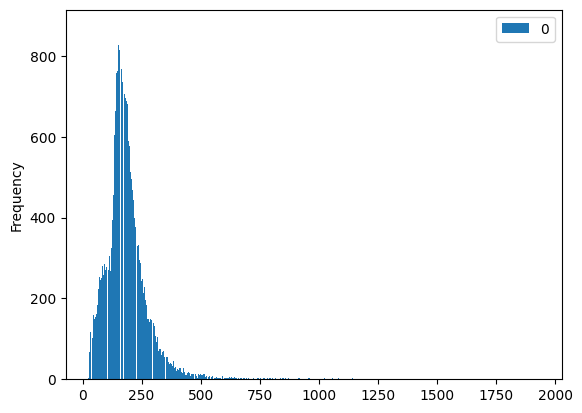

In [93]:
import pandas as pd
df = pd.DataFrame(ds['length'])
ax = df.plot.hist(bins=2048)


In [30]:
ds

Dataset({
    features: ['messages', 'text', 'length'],
    num_rows: 109355
})

In [29]:
ds.to_json('sft_train_dataset_below_2048_chat_format.json', orient="records")


Creating json from Arrow format:   0%|          | 0/110 [00:00<?, ?ba/s]

188559921

In [31]:
d_test.to_json('sft_validation_dataset_chat_format.json', orient="records")

Creating json from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

11603537

In [41]:
ds_1024.to_json('sft_train_dataset_below_1024_chat_format.json', orient="records")
d_test_1024.to_json('sft_validation_dataset_below_1024_chat_format.json', orient="records")


Creating json from Arrow format:   0%|          | 0/110 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

11371409

In [42]:
ds_1024


Dataset({
    features: ['messages', 'text', 'length'],
    num_rows: 109217
})

In [43]:
d_test_1024

Dataset({
    features: ['messages', 'text', 'length'],
    num_rows: 7280
})

In [ ]:
response_template = "<|assistant|>\n" 
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer = tokenizer)
training_args = TrainingArguments(
    output_dir="sft_stablelm_zephyr_3b",  # directory to save and repository id
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=3,          # batch size per device during training
    gradient_accumulation_steps=2,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=10,                       # log every 10 steps
    save_strategy="steps",                  # save checkpoint every step
    save_steps=100,                         # save checkpoint every 100 steps
    evaluation_strategy="steps",            # evaluate every step
    eval_steps=100,                         # evaluate every 100 steps
    save_total_limit=2,                     # only keep two checkpoints
    load_best_model_at_end=True,            # load best model at the end of training
    metric_for_best_model="eval_loss",      # metric to use for best model
    learning_rate=2e-4,                     # learning rate, based on QLoRA paper
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32 precision
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",           # use constant learning rate scheduler
    report_to="tensorboard",                # report metrics to tensorboard
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    dataset_text_field="text",
    max_seq_length=2048,
    tokenizer=tokenizer,
    packing=True,
    # peft_config=peft_config,
)

checkpoint_dir = training_args.output_dir
if os.path.isdir(checkpoint_dir):
    checkpoints = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) if d.startswith("checkpoint-")]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print(f"Resuming from checkpoint {latest_checkpoint}")
    else:
        latest_checkpoint = None
else:
    latest_checkpoint = None

# Start training, the model will be automatically saved to the output directory
trainer.train(resume_from_checkpoint=latest_checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
d:\ProgramData\Anaconda3\envs\MNLP\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/12027 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
d:\ProgramData\Anaconda3\envs\MNLP\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\MNLP\lib\site-packages\transformers\models\stablelm\modeling_stablelm.py:485: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
